In [3]:
import datetime
import os
import xarray as xr
import metpy
import cartopy.crs as ccrs
from pyresample import geometry, grid
import numpy as np
import matplotlib.pyplot as plt
import netCDF4

pc = ccrs.PlateCarree()
pc_extents = [-124.25, -114.25, 32.25, 42.25]
pc_params = pc.proj4_params
target_extents = [pc_extents[0],
                    pc_extents[2],
                    pc_extents[1],
                    pc_extents[3]]
target_rows = 500
target_cols = 500
shape = [target_rows, target_cols]

/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [32]:
import json
paramsdict = {'lon0': pc_extents[0], 'lon1': pc_extents[1], 'lat0': pc_extents[2], 'lat1': pc_extents[3], 
        'target_rows':500, 'target_cols':500}
with open('params.json', 'w', encoding='utf-8') as f:
    json.dump(paramsdict, f, ensure_ascii=False, indent=4)

In [33]:
def download_and_convert_files(jday_0, jday_f, year, band):
    for jday in range(jday_0, jday_f+1):
        for hour in range(24):
            if hour < 10:
                download_files(year, str(jday), '0' + str(hour), band)
            else:
                download_files(year, str(jday), str(hour), band)
            convert_files()

def convert_files():
    convert_log = open("../../GOES_Files/convert_log.txt", "w")
    fail_log = open("../../GOES_Files/fail_log.txt", "w")
    for file in os.listdir('../../GOES_Files/nc_files/'):
        try:
            data = xr.open_dataset('../../GOES_Files/nc_files/' + file)
            dat = data.metpy.parse_cf('Rad')
            geos = dat.metpy.cartopy_crs
            rad = dat.data

            fk1 = float(data.metpy.parse_cf('planck_fk1'))
            fk2 = float(data.metpy.parse_cf('planck_fk2'))
            bc1 = float(data.metpy.parse_cf('planck_bc1'))
            bc2 = float(data.metpy.parse_cf('planck_bc2'))
            bt = (fk2/(xr.ufuncs.log(fk1/rad + 1)) - bc1)/bc2
            bt = np.asarray(bt)

            goes_params = geos.proj4_params

            source_area = geometry.AreaDefinition.from_cf(data)
            target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)

            result = grid.get_resampled_image(target_area, source_area, bt)
            np.save('../../GOES_Files/npy_files/' + file[:-3], result)
            data.close()
            os.remove('../../GOES_Files/nc_files/' + file)
            convert_log.write('\n' + file)

        except:
            fail_log.write('\n' + file)
    convert_log.close()
    fail_log.close()

def download_files(year, jday, utchr, band):
    """
    appends to file for using cat ../GCPurls.txt | gsutil cp -I ./
    downloads all files in a given hour
    band should be two digits
    all inputs are strings
    """
    open("../../GOES_Files/GCPurls.txt", "w").close()
    urls = open("../../GOES_Files/GCPurls.txt", "a")
    time_log = open("../../GOES_Files/time_log.txt", "a")
    prefix = 'gs://gcp-public-data-goes-17/ABI-L1b-RadC/'
    code = year + jday + utchr 
    urls.write(prefix + year + '/' + jday + '/' + utchr + '/' + 'OR_ABI-L1b-RadC-M*C' + band + '_G17_s' + code + '*.nc' + '\n')
    # print(prefix + year + '/' + jday + '/' + utchr + '/' + 'OR_ABI-L1b-RadC-M*C' + band + '_G17_s' + code + '*.nc' + '\n')
    date = datetime.datetime.strptime(year[2:] + jday, '%y%j').date()
    date = date.strftime('%m/%d/%Y')
    time_log.write('\n' + date + ' UTC ' + utchr + ' band ' + band)
    urls.close()
    time_log.close()
    !cat ../../GOES_Files/GCPurls.txt | gsutil -m cp -I ../../GOES_Files/nc_files

In [19]:
def convert_files(file):
    data = xr.open_dataset('../../landsat_files/' + file)
    dat = data.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs
    rad = dat.data

#     fk1 = float(data.metpy.parse_cf('planck_fk1'))
#     fk2 = float(data.metpy.parse_cf('planck_fk2'))
#     bc1 = float(data.metpy.parse_cf('planck_bc1'))
#     bc2 = float(data.metpy.parse_cf('planck_bc2'))
#     bt = (fk2/(xr.ufuncs.log(fk1/rad + 1)) - bc1)/bc2
#     bt = np.asarray(bt)

    goes_params = geos.proj4_params

    source_area = geometry.AreaDefinition.from_cf(data)
    target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)

    result = grid.get_resampled_image(target_area, source_area, rad)
    np.save('../../landsat_files/' + file[:-3], result)
    data.close()
#     os.remove('../../landsat_files/' + file)

In [25]:
file = 'OR_ABI-L1b-RadC-M6C02_G17_s20212471851176_e20212471853549_c20212471853570.nc'
data = xr.open_dataset('../../landsat_files/' + file)
dat = data.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs
rad = dat.data

#     fk1 = float(data.metpy.parse_cf('planck_fk1'))
#     fk2 = float(data.metpy.parse_cf('planck_fk2'))
#     bc1 = float(data.metpy.parse_cf('planck_bc1'))
#     bc2 = float(data.metpy.parse_cf('planck_bc2'))
#     bt = (fk2/(xr.ufuncs.log(fk1/rad + 1)) - bc1)/bc2
#     bt = np.asarray(bt)

goes_params = geos.proj4_params

source_area = geometry.AreaDefinition.from_cf(data)
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)

result = grid.get_resampled_image(target_area, source_area, rad)
np.save('../../landsat_files/' + file[:-3], result, allow_pickle=False)
data.close()
#     os.remove('../../landsat_files/' + file)

/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [20]:
convert_files('OR_ABI-L1b-RadC-M6C02_G17_s20212471851176_e20212471853549_c20212471853570.nc')

/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


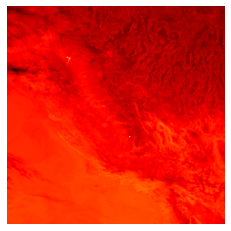

In [5]:
img_array = np.load('../../GOES_Files/npy_files/OR_ABI-L1b-RadC-M3C07_G17_s20183190037189_e20183190039574_c20183190040006.npy')
plt.imshow(img_array, aspect='equal', cmap='hot')
plt.axis('off')
plt.show()

In [8]:
def convert_files_fdcc(path, file):
    data = xr.open_dataset(path + file) 
    dat = data.metpy.parse_cf('Mask')
    geos = dat.metpy.cartopy_crs
    bcm = dat.data

    goes_params = geos.proj4_params
    source_area = geometry.AreaDefinition.from_cf(data)
    target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)

    result = grid.get_resampled_image(target_area, source_area, bcm)
    np.save(path + file[:-3], result) 
    data.close()
#     os.remove('../../GOES_Files/nc_files/' + file) 

In [9]:
convert_files_fdcc('../../landsat_files/', 'OR_ABI-L2-FDCC-M6_G17_s20212471851176_e20212471853549_c20212471854128.nc')

/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/sharedData2/nshakoor/.conda/envs/fires36/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
